In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
from typing import List

In [3]:
df = pd.read_csv("housing.csv")

### The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value')


Look at the `median_house_value` variable. Does it have a long tail?


<Axes: >

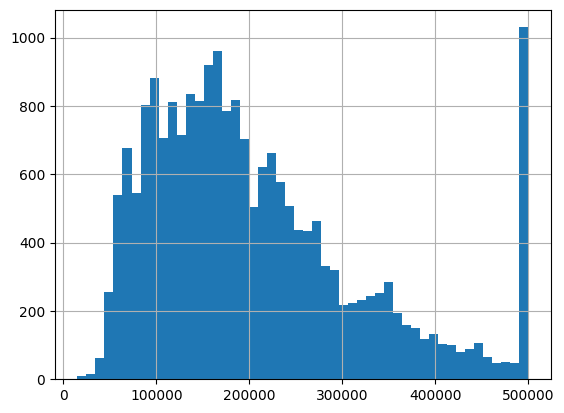

In [4]:
# does it have a long tail distribution
df["median_house_value"].hist(bins=50)

<Axes: xlabel='median_house_value', ylabel='Count'>

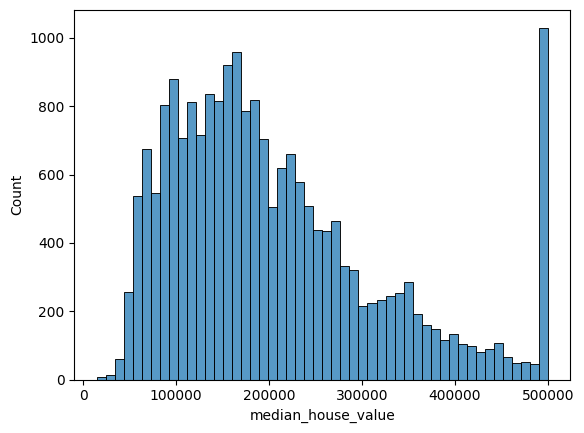

In [5]:
sns.histplot(df["median_house_value"], bins=50)

Note: the high amount in the 500,000 range is likely from how it was coded; any property of >$500,000 was likely just coded as 500,000. There's likely a long tail of outcomes that was just labeled as 500,000.

Let's log-transform it


<Axes: xlabel='median_house_value', ylabel='Count'>

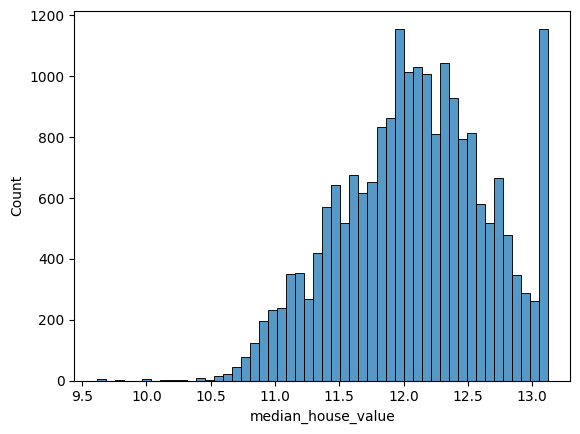

In [6]:
sns.histplot(np.log1p(df["median_house_value"]), bins=50)

Still imperfect but the range is more condensed and the distribution looks more normalized.


1. First, keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'
2. Use only the following columns:

```{text}
'latitude',
'longitude',
'housing_median_age',
'total_rooms',
'total_bedrooms',
'population',
'households',
'median_income',
'median_house_value'
```


In [7]:
subset_df = df[df["ocean_proximity"].isin(["<1H OCEAN", "INLAND"])][
    [
        "latitude",
        "longitude",
        "housing_median_age",
        "total_rooms",
        "total_bedrooms",
        "population",
        "households",
        "median_income",
        "median_house_value",
    ]
]

There's one feature with missing values. What is it?


In [8]:
feature_with_missing_value = ""
for col in subset_df.columns:
    if subset_df[col].isnull().any():
        feature_with_missing_value = col
        break
print(f"feature with missing value: {feature_with_missing_value}")

feature with missing value: total_bedrooms


What's the median (50% percentile) for variable 'population'?

1. 995
2. 1095
3. 1195
4. 1295


In [9]:
subset_df["population"].median()

1195.0

### Prepare and split the dataset

1. Shuffle the dataset (the filtered one you created above), use seed 42.
2. Split your data in train/val/test sets, with 60%/20%/20% distribution.
3. Apply the log transformation to the median_house_value variable using the np.log1p() function.


In [10]:
seed = 42
np.random.seed(seed)

In [11]:
total_rows = subset_df.shape[0]
n_validation = int(total_rows * 0.2)
n_test = int(total_rows * 0.2)
n_train = total_rows - n_validation - n_test
print(f"total rows: {total_rows}")
print(f"n_train: {n_train}")
print(f"n_validation: {n_validation}")
print(f"n_test: {n_test}")

total rows: 15687
n_train: 9413
n_validation: 3137
n_test: 3137


In [12]:
# shuffle dataset before pulling
subset_df = subset_df.sample(frac=1).reset_index(drop=True)

# get subsets
df_val = subset_df[:n_validation]
df_test = subset_df[n_validation : n_validation + n_test]
df_train = subset_df[n_validation + n_test :]

In [13]:
y_val = np.log1p(df_val["median_house_value"].values)
y_test = np.log1p(df_test["median_house_value"].values)
y_train = np.log1p(df_train["median_house_value"].values)

In [14]:
# remove labels from the main dataset
del df_val["median_house_value"]
del df_test["median_house_value"]
del df_train["median_house_value"]

In [20]:
x_train = df_train
x_val = df_val
x_test = df_test

### Question 3

- We need to deal with missing values for the column from Q1.
  We have two options: fill it with 0 or with the mean of this variable.
- Try both options. For each, train a linear regression model without regularization using the code from the lessons.
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the RMSE of each option.
- Round the RMSE scores to 2 decimal digits using round(score, 2)
- Which option gives better RMSE?
- Options:
  - With 0
  - With mean
  - Both are equally good


In [15]:
df_train.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
6274,38.62,-121.37,43.0,1077.0,199.0,447.0,182.0,3.0139
6275,34.13,-117.66,17.0,3229.0,405.0,1289.0,407.0,6.3842
6276,39.00,-121.00,4.0,170.0,23.0,93.0,27.0,10.9891
6277,34.03,-117.17,33.0,4583.0,648.0,1760.0,638.0,6.3308
6278,38.64,-121.41,38.0,1384.0,287.0,682.0,280.0,1.9167


Let's say that we're going to use `housing_median_age`, `total_rooms`, and `median_income` as the predictive variables.


In [17]:
y_train

array([11.65789989, 12.63493196, 12.65236295, ..., 12.3647886 ,
       11.33141558, 12.50766132])

In [19]:
w0 = 100
w1 = 0.01  # for housing_median_age
w2 = 0.5  # for total_rooms
w3 = 0.5  # for median_income
weights = np.array([w1, w2, w3])

In [38]:
def simple_linear_regression(xi: List[float]) -> float:
    """Simplie for-loop implementation, where we already have hardcoded weights
    and return a prediction.

    Of note: the `y` value returned is a log1p value, so we need to convert it
    back to the original value by using `np.expm1(y)`.

    Takes the form y = m1x1 + m2x2 + m3x3 + b
    """
    assert len(xi) == 3
    pred = 0
    pred += w0
    for idx in range(len(xi)):
        pred += xi[idx] * weights[idx]
    return pred

In [39]:
example = x_train.iloc[0][["housing_median_age", "total_rooms", "median_income"]].values

In [40]:
pred_example = simple_linear_regression(example)
print(f"prediction: {pred_example}")

prediction: 640.43695


Now that we have this simple for-loop implementation, let's vectorize it


In [42]:
def dot(x, y) -> float:
    """Dot product implementation."""
    assert len(x) == len(y)
    return sum([x_i * y_i for x_i, y_i in zip(x, y)])

Let's add w0 to the weight matrix (since this technically is a weight) and prepend a 1 at the beginning of the input vector


In [45]:
weights = np.array([w0, w1, w2, w3])

In [59]:
def vectorized_linear_regression(xi: List[float]) -> float:
    """Vectorized implementation of linear regression."""
    assert len(xi) == 3
    # prepend '1' to xi
    xi_modified = np.insert(xi, 0, 1)
    # get dot product of Xi^(T) and weights
    return dot(xi_modified, weights)

The linear regression model can be expressed as $$y = XW + \epsilon$$

We need to solve for $$W$$ to get our weight matrix. If X is invertible, the solution is simple:

$$X^{-1}y = X^{-1}XW$$
$$X^{-1}y = IW = W$$

But, it's unlikely that X will be invertible. This is because only square matrices are invertible, and it's likely that X will have many more rows (observations) than columns (features).

Another approach we can use is taking $X^{T}X$, which is a square matrix.

$$y = XW$$
$$X^{T}y = X^{T}XW$$
$$(X^{T}X)^{-1}X^{T}y = (X^{T}X)^{-1}X^{T}XW = IW = W$$
$$(X^{T}X)^{-1}X^{T}y = W$$

This is called the "normal equation" of linear regression. If $X^{T}X$ is invertible, then we can find, in a single step, the optimal weights $W$ that solves the equation $XW = y$

Questions:

1. What are the cases where we could find that $X^{T}X$ is invertible?
   The matrix $X^{T}X$ may be invertible in cases of simple problems, where the dataset is not very large and the values of X allow for $X^{T}X$ to be inverted.

2. What do we do if $X^{T}X$ is invertible?
   If it is invertible, great! That means that your linear regression problem can be solved in a single step. By simply computing the values above, you can find the optimal weights $W$ for your problem. This has two key advantages:

- Simple and interpretable: The normal equation provides a clear interpretation of the relationship between predictor variables and target values.
- Closed-form solution: It allows you to obtain the regression coefficients without iterative optimization methods like gradient descent.

3. What are some problems with calculating $X^{T}X$? Even if in theory, $X^{T}X$ is possible, are there some problems that can still arise when calculating it?
   When calculating $X^{T}X$, several problems can arise, even if theoretically the value of $X^{T}X$ is possible (i.e., you can calculate it on pen and paper):

   - Computational complexity: calculating $X^{T}X$ can be really expensive. The calculation for the matrix inversion is generally $O(n^{3})$, making it infeasible for large datasets. In addition, matrix inversion requires storing both the original matrix ($X^{T}X$) and the inverted matrix ($(X^{T}X)^{-1}$) in memory, which can take up large amounts of RAM.
   - Numerical instability: computers are imperfect with dealing with floating point logic (see [this](https://en.wikipedia.org/wiki/Floating-point_error_mitigation) Wikipedia article about floating point errors). When the program is dealing with many significant digits of decimal points or with small decimal point numbers, it will likely make some errors, and these errors can compound and cascade, leading to your output being much different than what you would expect.

    These are two cases where, even if technically $X^{T}X$ can be found (i.e., you can calculate it on pen and paper), a computer software might not be able to calculate it

4. When can the matrix $X^{T}X$ be non-invertible?

There are some cases where we aren't going to be able to invert $X^{T}X$, which can be due to the underlying nature of the data itself.

5. What can we do if the matrix $X^{T}X$ is not invertible?


In [58]:
vectorized_linear_regression(example)

4
4


640.43695